## The relationship between COVID policies and cases

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import roc_curve, roc_auc_score

### Analyze covid cases by state

In [2]:
covid = pd.read_csv("data/covid.csv")
covid = covid[covid["Location"] != "United States"]
covid["COVID_rate (%)"] = 100*(covid["Oct_2020_Cases"] / covid["Total Population"])

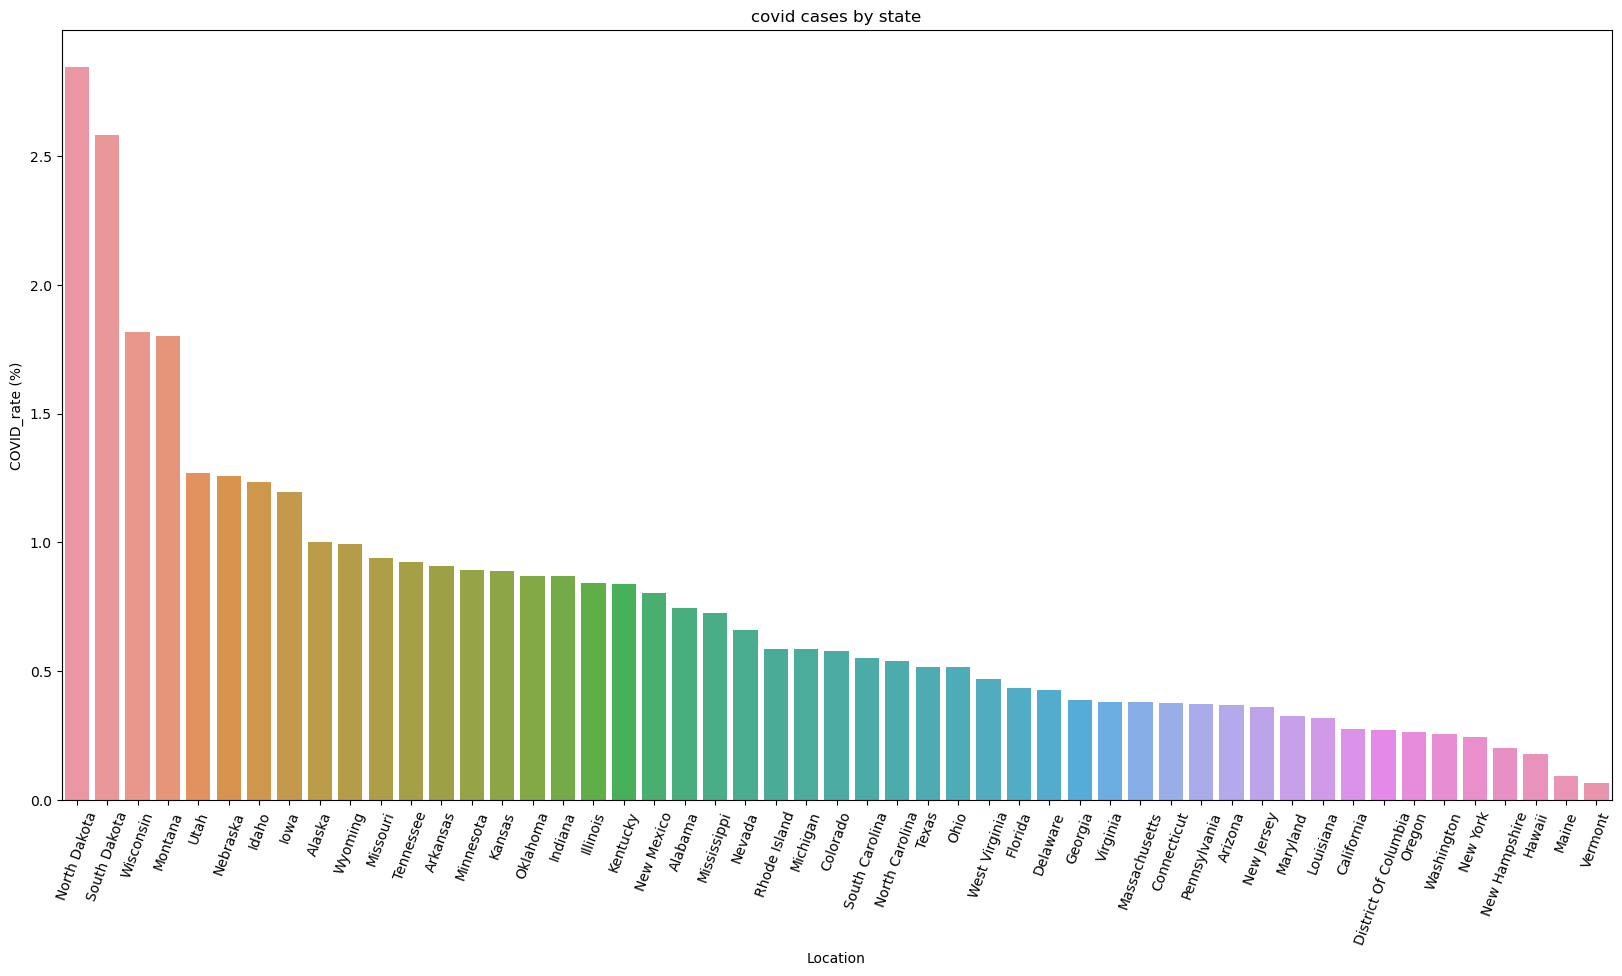

In [3]:
covid_sorted = covid.sort_values("COVID_rate (%)", ascending = False)
covid_sorted.head()

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=covid_sorted, x="Location", y="COVID_rate (%)")
plt.title("covid cases by state")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

### How different gathering bans affect covid affection rate?

array(['No Limit', '>50 Prohibited', 'All Gatherings Prohibited',
       '>10 Prohibited', '>25 Prohibited'], dtype=object)

/tmp/ipykernel_1155/3742168016.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=70);


,COVID_rate (%)
Large Gatherings Ban,
>50 Prohibited,0.923554
>25 Prohibited,0.919531
No Limit,0.906760
>10 Prohibited,0.534330
All Gatherings Prohibited,0.416476


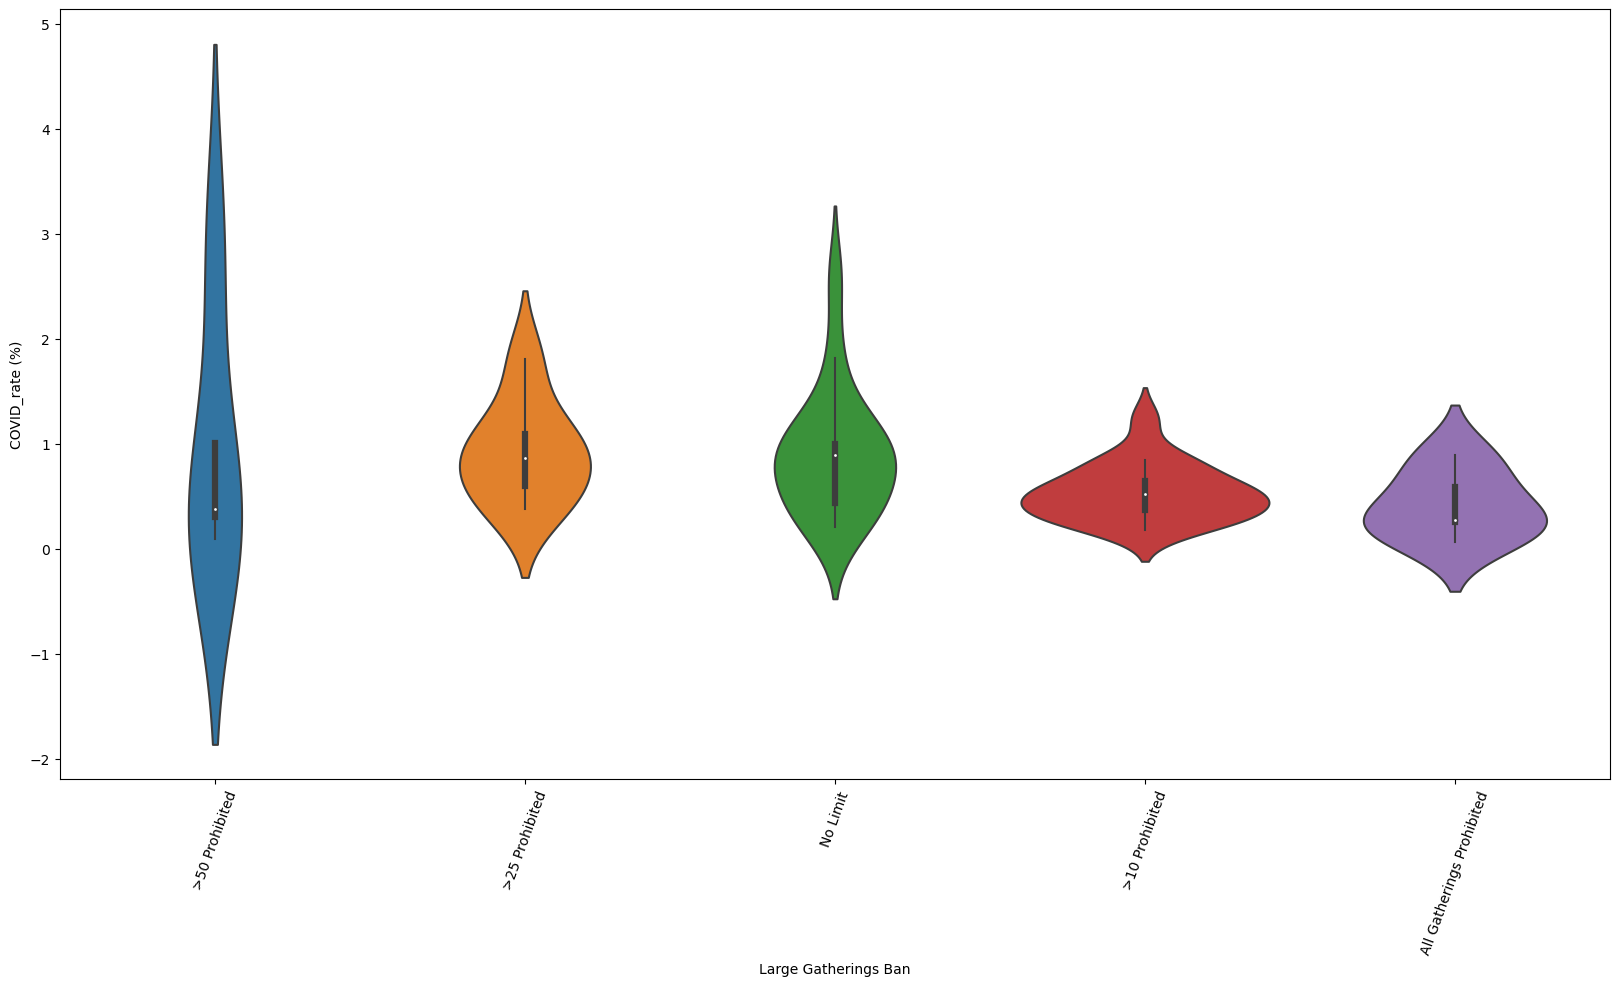

In [4]:
display(covid["Large Gatherings Ban"].unique())
covid_gathering_bans = (pd.DataFrame(covid.groupby("Large Gatherings Ban")["COVID_rate (%)"].mean())
                        .sort_values("COVID_rate (%)", ascending = False))
covid_gathering_bans


fig, ax = plt.subplots(figsize=(20, 10))
#sns.barplot(data=covid_sorted, x="Location", y="COVID_rate (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);
sns.violinplot(data=covid, x="Large Gatherings Ban", y="COVID_rate (%)", order=covid_gathering_bans.index)
#sns.lineplot(
#    x=covid_gathering_bans.index, 
#    y=covid_gathering_bans["COVID_rate (%)"], 
#    style="event"
#)
covid_gathering_bans

we could see that gathering bans are useful in preventing the spread of COVID

### regression covid infection rate on other variables

In [15]:
features = ["COVID_rate (%)", "Depression.2020", "Employer", "Medicaid", "Medicare", "Uninsured", "Large Gatherings Ban", "Restaurant Limits"]
covid1 = covid[features]

In [16]:
numerical = list((covid1.dtypes[covid1.dtypes == 'float64'].index) | (covid1.dtypes[covid1.dtypes == 'int64'].index))
categorical = list((covid1.dtypes[covid1.dtypes != 'float64'].index) & (covid1.dtypes[covid1.dtypes != 'int64'].index))
categorical

/tmp/ipykernel_1155/187220128.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  numerical = list((covid1.dtypes[covid1.dtypes == 'float64'].index) | (covid1.dtypes[covid1.dtypes == 'int64'].index))
/tmp/ipykernel_1155/187220128.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  categorical = list((covid1.dtypes[covid1.dtypes != 'float64'].index) & (covid1.dtypes[covid1.dtypes != 'int64'].index))


['Large Gatherings Ban', 'Restaurant Limits']

In [17]:
def ohe(data, column):
    enc = OneHotEncoder()
    enc.fit(data[column])
    encoded_data = pd.DataFrame(enc.transform(data[column]).toarray().astype(int))
    encoded_data.columns = enc.get_feature_names_out()
    encoded_data = encoded_data.set_index(data.index)
    return encoded_data

In [18]:
ohe_df = pd.concat([covid1[numerical], ohe(covid1[categorical], categorical)], axis=1)
ohe_df.head()

,COVID_rate (%),Depression.2020,Employer,Medicaid,Medicare,Uninsured,Large Gatherings Ban_>10 Prohibited,Large Gatherings Ban_>25 Prohibited,Large Gatherings Ban_>50 Prohibited,Large Gatherings Ban_All Gatherings Prohibited,Large Gatherings Ban_No Limit,Restaurant Limits_-,Restaurant Limits_New Service Limits,Restaurant Limits_Newly Closed to Indoor Dining,Restaurant Limits_Reopened to Dine-in Service,Restaurant Limits_Reopened to Dine-in Service with Capacity Limits
0,0.745250,33.8,0.469639,0.195321,0.158831,0.101714,0,0,0,0,1,0,0,0,1,0
1,1.001716,27.1,0.481289,0.213177,0.094280,0.120369,0,0,0,0,1,0,0,0,1,0
2,0.367290,27.2,0.444624,0.223905,0.155921,0.106147,0,0,1,0,0,0,1,0,0,0
3,0.906918,28.3,0.418750,0.272687,0.156044,0.082839,0,0,0,0,1,0,0,0,0,1
4,0.276735,29.7,0.473513,0.263108,0.109437,0.071597,0,0,0,1,0,0,0,0,0,1


In [19]:
X = ohe_df.drop("COVID_rate (%)", axis=1)
y = ohe_df["COVID_rate (%)"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [21]:
model = LinearRegression().fit(X_train, y_train)

In [22]:
print('model intercept :', model.intercept_)
print('model coefficients : ', model.coef_)
print('Training Accuracy: ', model.score(X_train, y_train))

model intercept : 3.819279249016801
model coefficients :  [-0.01522958 -2.86343683 -3.30809215 -3.93673412  2.1371601  -0.03378686
  0.4202171  -0.38477096 -0.10947185  0.10781256  1.2697461  -0.22060498
 -0.1507367  -0.42249257 -0.47591184]
Training Accuracy:  0.7225629280213828


In [23]:
test_predictions = model.predict(X_test)
mean_squared_error(y_test, test_predictions)

0.43652419531467324